In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from normalized_cuts import *
from preprocessing import *
from Preprocesser import *
from superpixel import *
from unmixing import *
from segmentation_evaluation import *
# Configs for Notebooks
os.chdir('c:\\Users\\apopo\\Desktop\\Research')
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

Dataset Importing & Preprocessing

In [2]:
dataset_name = 'fields_data_2022'
h5_import = h5py.File("C:/Users/apopo/Desktop/Research/Data/fields_data_2022.h5",'r+').get('Cube/resultarray/inputdata')
hyperspectral_cube = np.array(h5_import)
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [2])
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [1])
hyperspectral_cube = hyperspectral_cube[5:205, 5:205, :].copy()
nx,ny,nb = hyperspectral_cube.shape
del h5_import

In [3]:
preprocessing_pipeline = Preprocesser(data=hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

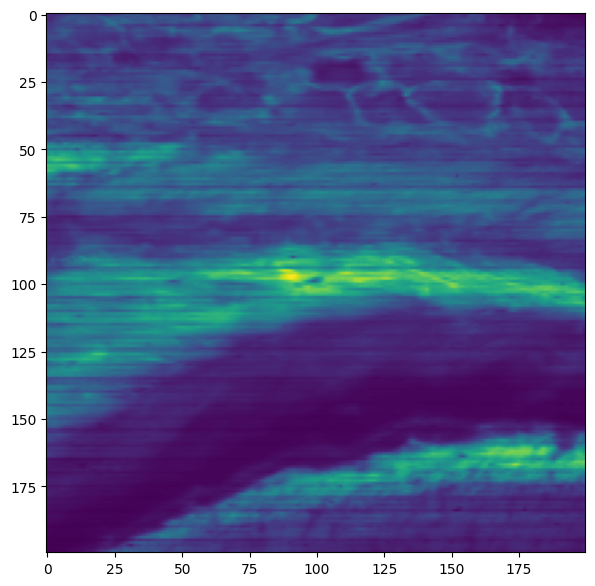

In [4]:
plt.imshow(hyperspectral_cube[:,:,0])

SLIC Superpixel Generation

In [5]:
n_superpixels = 1250 #2500
slic_m_param = 2    #2
assignments, centers = generate_SLIC_assignments(data = hyperspectral_cube, n_superpixels = n_superpixels, slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = generate_SLIC_superpixels(data = hyperspectral_cube, assignments = assignments)
n_superpixels = len(np.unique(assignments))

Adjusting n_superpixels: 1600
Created 1600 superpixels


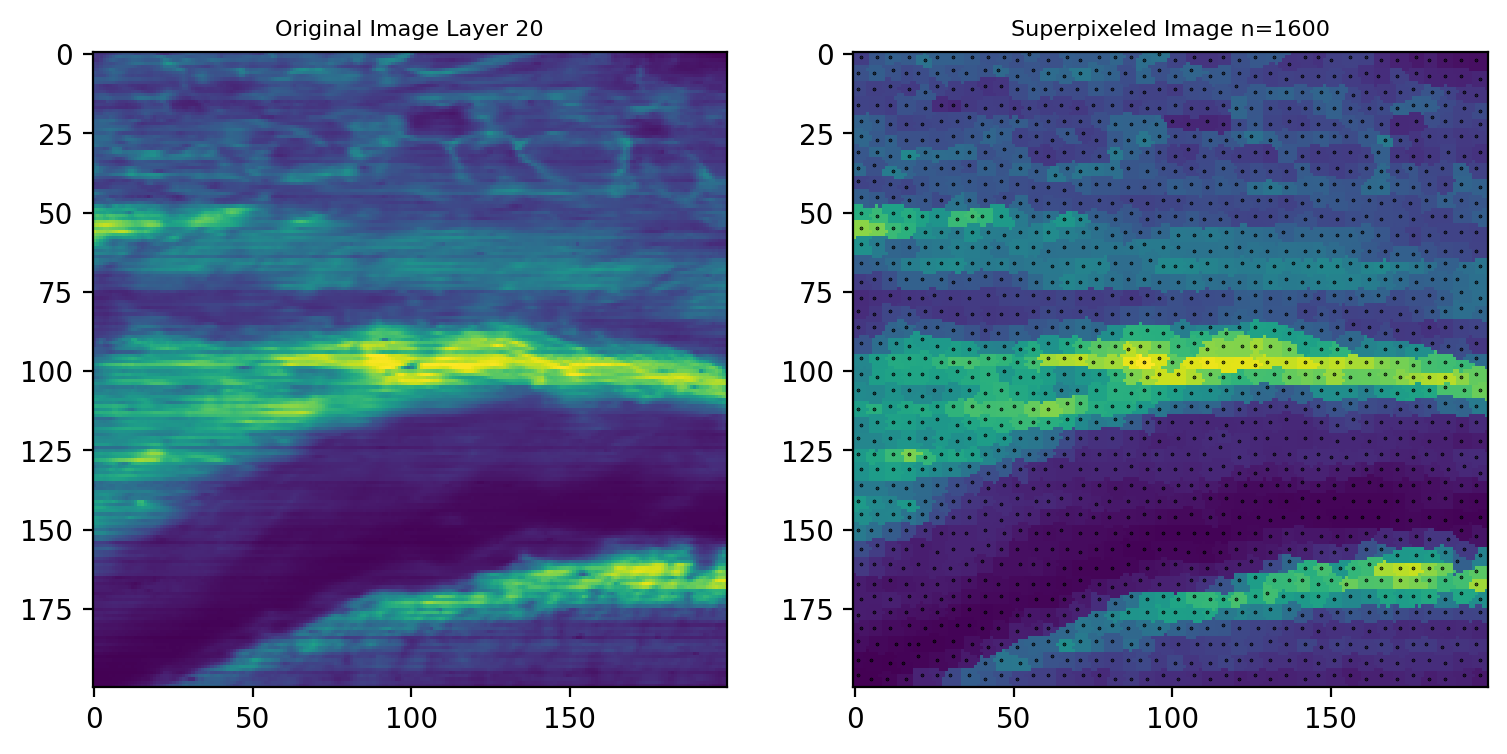

In [6]:
fig, ax = plt.subplots(1,2, dpi=200);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='black', s=0.1);
ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

Spatial-Spectral Pixel Clustering

In [7]:
sigma_param = 0.01 # 0.1 -> 0.001           #0.01
spatial_limit = 35# 15 -> 25 in steps of 5 #15
ne = 5#number of endmembers

superpixel_cluster_labels, mean_cluster_spectra = single_ncuts(data=hyperspectral_cube,
                                                                superpixel_library=superpixel_library,
                                                                superpixel_centers=centers,
                                                                superpixel_assignments=assignments,
                                                                n_endmembers=ne,
                                                                spectral_sigma2_param=sigma_param,
                                                                spatial_kappa_param=spatial_limit,
                                                                spectral_metric='EUCLIDEAN')

labelled_img = assign_labels_onto_image(assignments, superpixel_cluster_labels)

Initial Clustering
Spectral + Unmixing Clustering


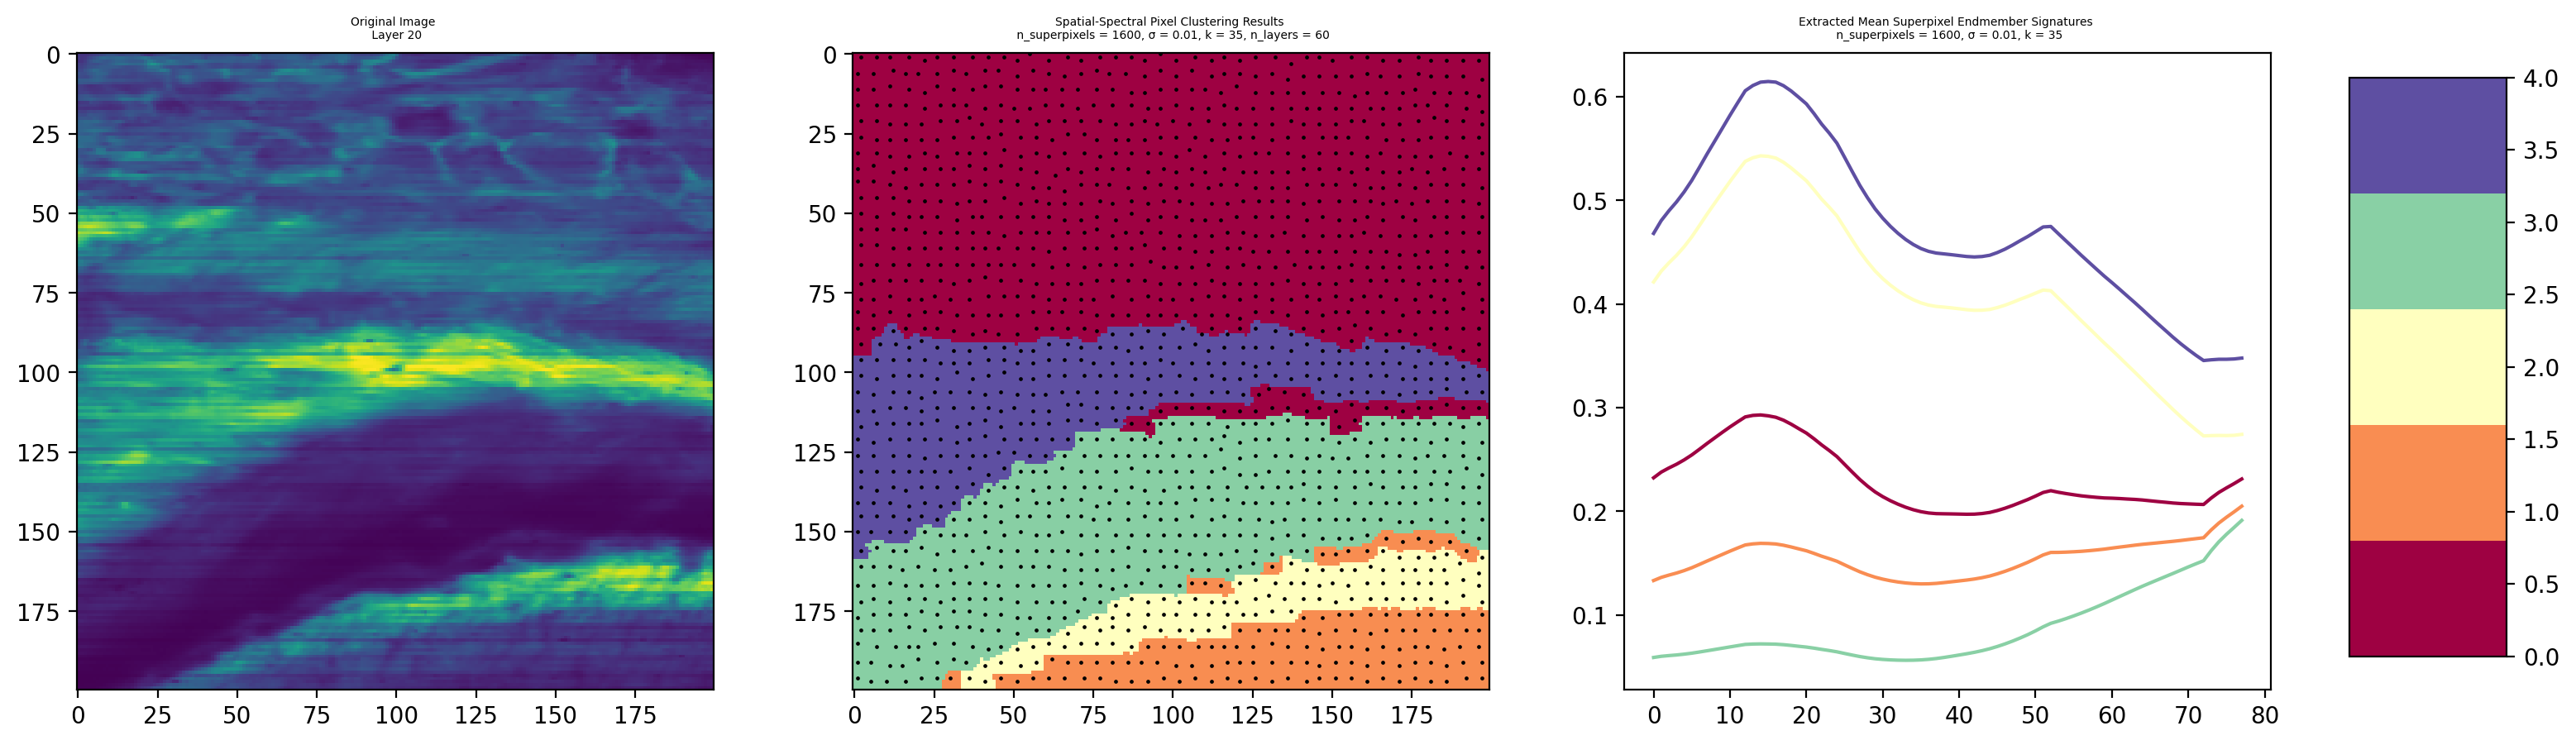

In [8]:
fig, ax = plt.subplots(1,3, figsize=(19,5), dpi=200);
layer_preview = 20
n_layers = 60
cmap = plt.get_cmap('Spectral', ne)
colors = cmap(list(np.unique(assignments)))

ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[0].set_title(f'Original Image \n Layer {layer_preview}', fontsize = 5);

im = ax[1].imshow(labelled_img, cmap = cmap, vmin = 0);
ax[1].scatter(centers[:,1], centers[:,0], c='black', s=0.5);
ax[1].set_title(f'Spatial-Spectral Pixel Clustering Results \n n_superpixels = {n_superpixels}, σ = {sigma_param}, k = {spatial_limit}, n_layers = {n_layers}' , fontsize = 5);

for i in range(ne):
    ax[2].plot(mean_cluster_spectra[:,i], color=colors[i])
ax[2].set_title(f'Extracted Mean Superpixel Endmember Signatures \n n_superpixels = {n_superpixels}, σ = {sigma_param}, k = {spatial_limit}', fontsize = 5);

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

Split up a chunk further


In [9]:
def calc_mean_label_signatures_v2(spectral_library  : np.ndarray,
                                  labels            : np.ndarray,
                                  ignore_label      : int = -1):
    """
    Description:
        Extract Mean Label Spectra Signature
    ===========================================
    Args:
        spectral_library (np.ndarray): _description_
        labels (np.ndarray): _description_
    ===========================================
    Returns:
        np.ndarray: _description_
    """
    nb, _ = spectral_library.shape
    unique_labels = np.unique(labels)
    if ignore_label in unique_labels:
        unique_labels = unique_labels[1::].copy()
    ne = len(unique_labels)
    mean_endmember_spectra = np.zeros((nb,ne))
    for i in range(ne):
        mean_endmember_spectra[:,i] = spectral_library[:,np.where(labels == unique_labels[i])[0]].mean(axis=1) 
    return mean_endmember_spectra

In [10]:
chunk_label = 3
subsegmented_labels = superpixel_cluster_labels.copy()
chunk_assignments = np.vectorize(lambda x: x if x in list(np.where(subsegmented_labels == chunk_label)[0]) else -1)(assignments)
chunk_superpixel_library = superpixel_library[:,(superpixel_cluster_labels == chunk_label)].copy()
chunk_superpixel_centers = centers[(superpixel_cluster_labels == chunk_label),:].copy()

In [16]:
chunk_sigma_param = 0.01 # 0.1 -> 0.001           #0.01
chunk_spatial_limit = 35# 15 -> 25 in steps of 5 #15

chunk_labels, chunk_spectra = superpixel_subsegment(data=hyperspectral_cube,
                                                                superpixel_library=chunk_superpixel_library,
                                                                superpixel_centers=chunk_superpixel_centers,
                                                                superpixel_assignments=chunk_assignments,
                                                                n_endmembers=2,
                                                                spectral_param=chunk_sigma_param,
                                                                spatial_param=chunk_spatial_limit,
                                                                spectral_metric='EUCLIDEAN')

subsegmented_labels[(superpixel_cluster_labels == chunk_label)] = np.vectorize(lambda x: chunk_label if x == 0 else ne)(chunk_labels)

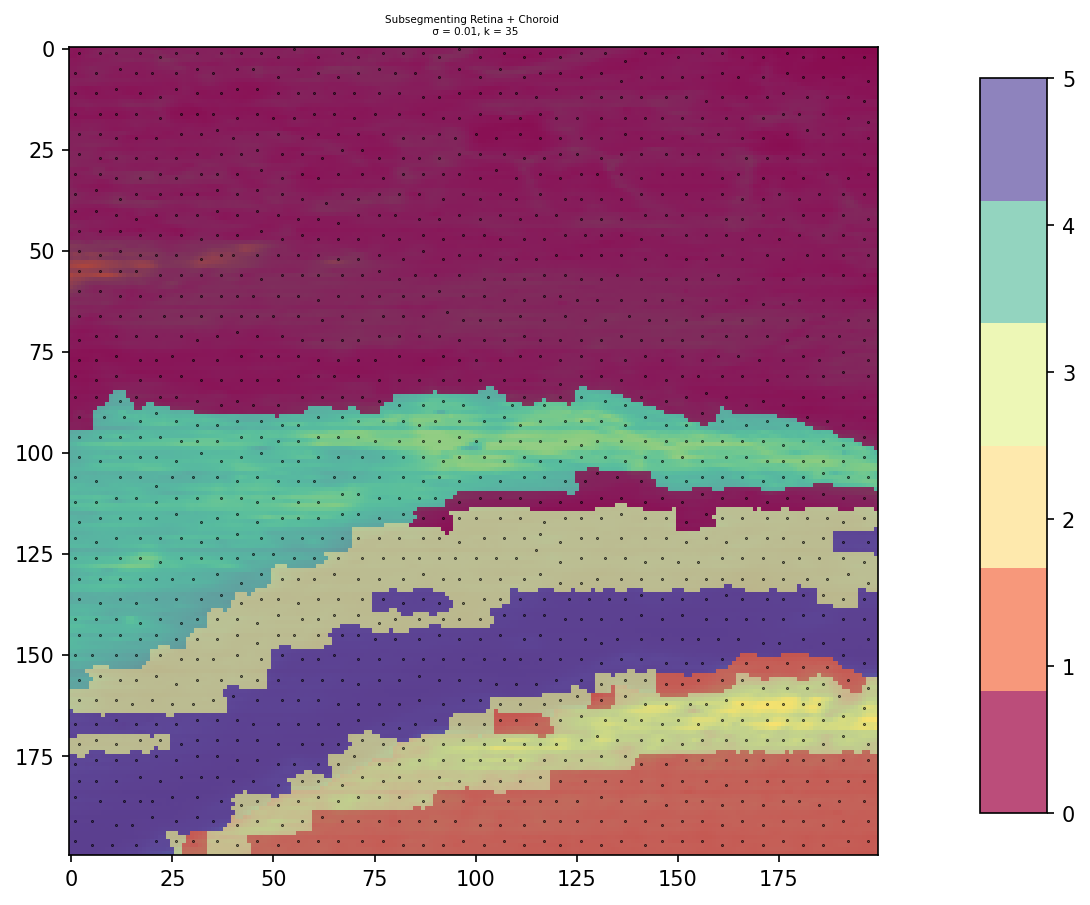

In [17]:
fig, ax = plt.subplots(1,1, dpi=150);
layer_preview = 20
iter_preview = 0
n_layers = 60

cmap = plt.get_cmap('Spectral', ne+1)
colors = cmap(list(np.unique(subsegmented_labels)))

ax.imshow(hyperspectral_cube[:,:,layer_preview], alpha = 0.9);
im = ax.imshow(assign_labels_onto_image(assignments, subsegmented_labels), cmap = cmap, alpha= 0.7, vmin = 0);
ax.scatter(centers[:,1], centers[:,0], c='black', s=0.1);
ax.set_title(f'Subsegmenting Retina + Choroid \n σ = {chunk_sigma_param}, k = {chunk_spatial_limit}' , fontsize = 5);

# ax[1].imshow(hyperspectral_cube[:,:,layer_preview], alpha = 0.9);
# im = ax[1].imshow(assign_labels_onto_image(assignments, superpixel_cluster_labels), cmap = cmap, alpha= 0.7, vmin = 0);
# ax[1].scatter(centers[:,1], centers[:,0], c='black', s=0.1);
# ax[1].set_title(f'Original Segmentation \n n_superpixels = {n_superpixels}, m = {slic_m_param}, σ = {sigma_param}, k = {spatial_limit},  n_layers = {n_layers}' , fontsize = 5);

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);
